# Evaluate and compare metrics 

In [1]:
from time import time
from translate.one_trans import initialize_translation_environment, translate_text
from common.load_config import load_all_configurations
from metrics.evaluation_transition import evaluate_translation

# Example usage
config_path = "/home/dudaji/Jun/llm-rag-chatbot/main/config_npu_translate.yaml"
all_configs = load_all_configurations(config_path)

# Print the loaded configurations
print("Configurations Loaded Successfully:")
print("Active Metrics:", all_configs["active_metrics"])
print("Device Config:", all_configs["device_config"])
print("Model Config:", all_configs["model_config"])
print("Evaluation Settings:", all_configs["evaluation_settings"])

Configurations Loaded Successfully:
Active Metrics: ['BLEU', 'METEOR', 'BERTScore', 'tps', 'power_consumption']
Device Config: {'type': 'npu:0:*', 'model': 'RNGD', 'count': 1}
Model Config: {'name': 'llama3.1-8B-Instruct', 'quantization': 'W8A8'}
Evaluation Settings: {'task': 'translation', 'output_dir': './results/translation'}


In [6]:
import json

# JSON 파일 읽기
with open("/home/dudaji/Jun/llm-rag-chatbot/result/translated_rngd.json", "r", encoding="utf-8") as file:
    translations_rngd = json.load(file)
    
# JSON 파일 읽기
with open("/home/dudaji/Jun/llm-rag-chatbot/result/translated_gpu.json", "r", encoding="utf-8") as file:
    translations_gpu = json.load(file)
    
target_lang = "English"  # 목표 언어



- 정답 reference 파일 읽어오기 

In [2]:
# Load the CSV file 
# 텍스트 파일 로더
def load_text_file(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    return [line.strip() for line in lines]

# 데이터 위치 
data_dir = "/home/dudaji/Jun/llm-rag-chatbot/data/flores/"

data_eng = load_text_file(f"{data_dir}/devtest.eng_Latn")
data_kor = load_text_file(f"{data_dir}/devtest.kor_Hang")

print(data_eng[0])
print(data_kor[0])

"We now have 4-month-old mice that are non-diabetic that used to be diabetic," he added.
"그는 ""현재 4개월 된 당뇨병에서 치료된 생쥐가 있다""고 덧붙였다."


In [5]:
translation_data = translations[0]
ref_text = data_eng[0]
metrics = evaluate_translation(translation_data["translation"], ref_text, target_lang, translation_data["elapsed_time"], all_configs["active_metrics"])
metrics

/home/dudaji/miniconda3/envs/langserve/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


{'BLEU': 0.0145,
 'METEOR': 0.2551,
 'tps': 16.161870831363245,
 'BERTScore': 0.7027}

In [10]:
import numpy as np

name1 = 'rngd'
name2 = 'gpu'

# Initialize data
num_metrics = 4  # BLEU, METEOR, BERTScore, TPS
metrics = {
    name1: np.full((num_metrics, len(translations_rngd)), np.nan),
    name2: np.full((num_metrics, len(translations_gpu)), np.nan),
}

for i in range(len(translations_rngd)):
    ref_text = data_eng[i] if i < len(data_eng) else ""  # 참조 텍스트 매칭

    # RNGD 메트릭 계산
    metrictemp = evaluate_translation(
        translations_rngd[i]["translation"],
        ref_text,
        target_lang,
        translations_rngd[i]["elapsed_time"],
        all_configs["active_metrics"]
    )
    metrics[name1][0, i] = metrictemp.get('BLEU', np.nan)
    metrics[name1][1, i] = metrictemp.get('METEOR', np.nan)
    metrics[name1][2, i] = metrictemp.get('BERTScore', np.nan)
    metrics[name1][3, i] = metrictemp.get('tps', np.nan)

    # GPU 메트릭 계산
    metrictemp1 = evaluate_translation(
        translations_gpu[i]["translation"],
        ref_text,
        target_lang,
        translations_gpu[i]["elapsed_time"],
        all_configs["active_metrics"]
    )
    metrics[name2][0, i] = metrictemp1.get('BLEU', np.nan)
    metrics[name2][1, i] = metrictemp1.get('METEOR', np.nan)
    metrics[name2][2, i] = metrictemp1.get('BERTScore', np.nan)
    metrics[name2][3, i] = metrictemp1.get('tps', np.nan)

/home/dudaji/miniconda3/envs/langserve/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


- Visualization 진행 

2025-01-04 04:56:27,832 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-04 04:56:27,839 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-04 04:56:27,878 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-04 04:56:27,884 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-04 04:56:28,002 - INFO - Using categorical units to plot a list of strings that are all parsable as 

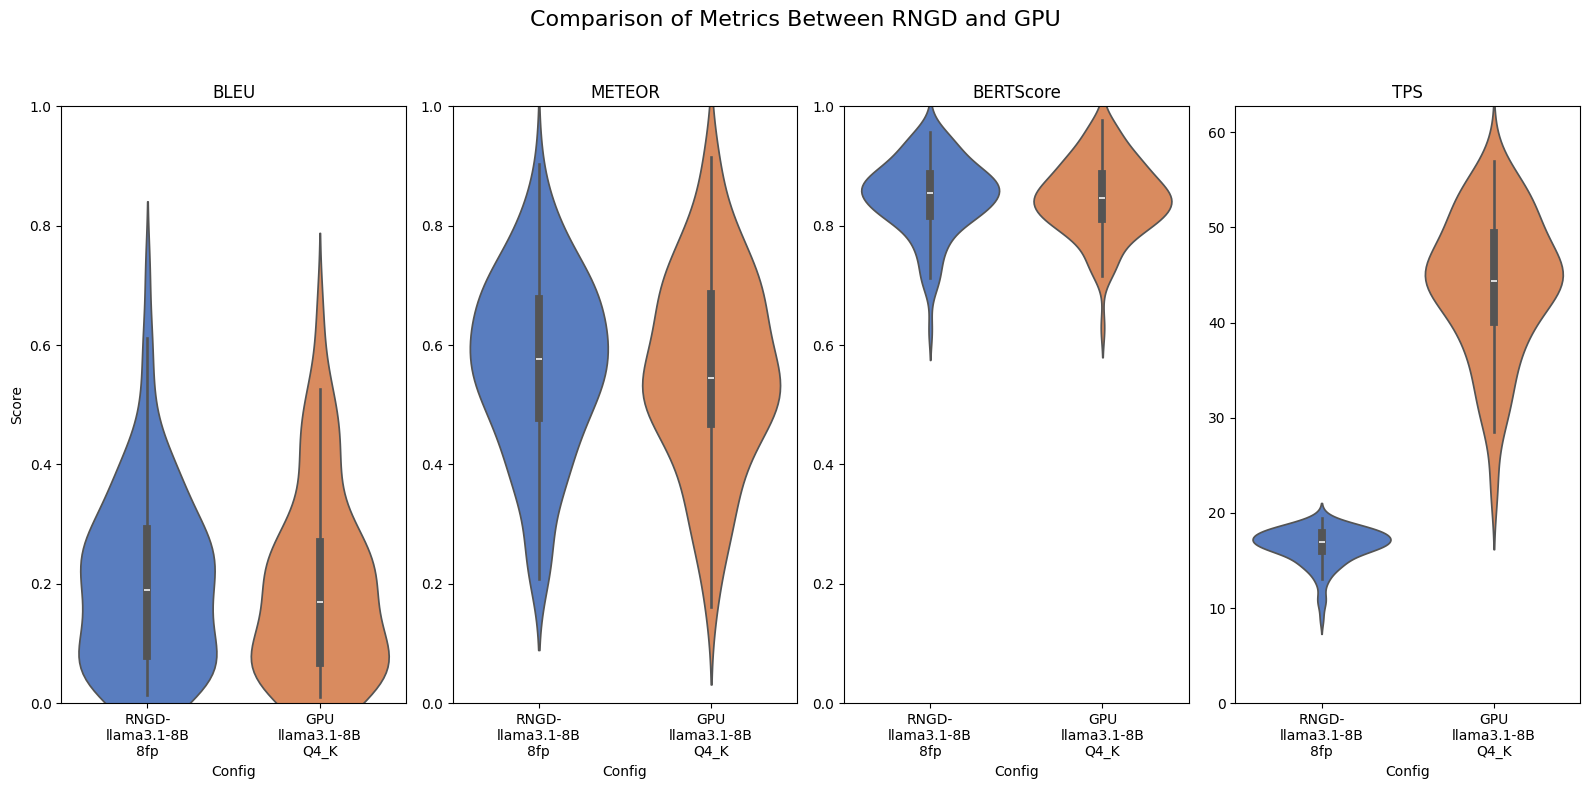

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 준비
metrics_labels = ["BLEU", "METEOR", "BERTScore", "TPS"]
num_metrics = len(metrics_labels)

# 각 메트릭 데이터 추출 및 NaN 제거
data = {
    label: {
        "rngd": metrics["rngd"][i, ~np.isnan(metrics["rngd"][i, :])],
        "gpu": metrics["gpu"][i, ~np.isnan(metrics["gpu"][i, :])]
    }
    for i, label in enumerate(metrics_labels)
}

# Subplot 구성
fig, axes = plt.subplots(1, num_metrics, figsize=(16, 8), sharey=False)

for idx, label in enumerate(metrics_labels):
    ax = axes[idx]
    
    # RNGD와 GPU 데이터를 하나로 묶기
    combined_data = [data[label]["rngd"], data[label]["gpu"]]
    
    # Violin plot 생성
    sns.violinplot(data=combined_data, ax=ax, palette="muted")
    
    # 각 subplot별 y축 범위 설정
    max_value = max([np.max(d) for d in combined_data if len(d) > 0])
    if idx<3:
        ax.set_ylim(0, 1)  # 최대값보다 약간 여유 추가
    else:
        ax.set_ylim(0, max_value + max_value * 0.1)  # 최대값보다 약간 여유 추가
    
    # 타이틀 및 축 설정
    ax.set_title(label)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["RNGD-\nllama3.1-8B\n8fp", "GPU\nllama3.1-8B\nQ4_K"])
    ax.set_xlabel("Config")
    if idx == 0:
        ax.set_ylabel("Score")

# 전체 그래프 제목 추가
fig.suptitle("Comparison of Metrics Between RNGD and GPU", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

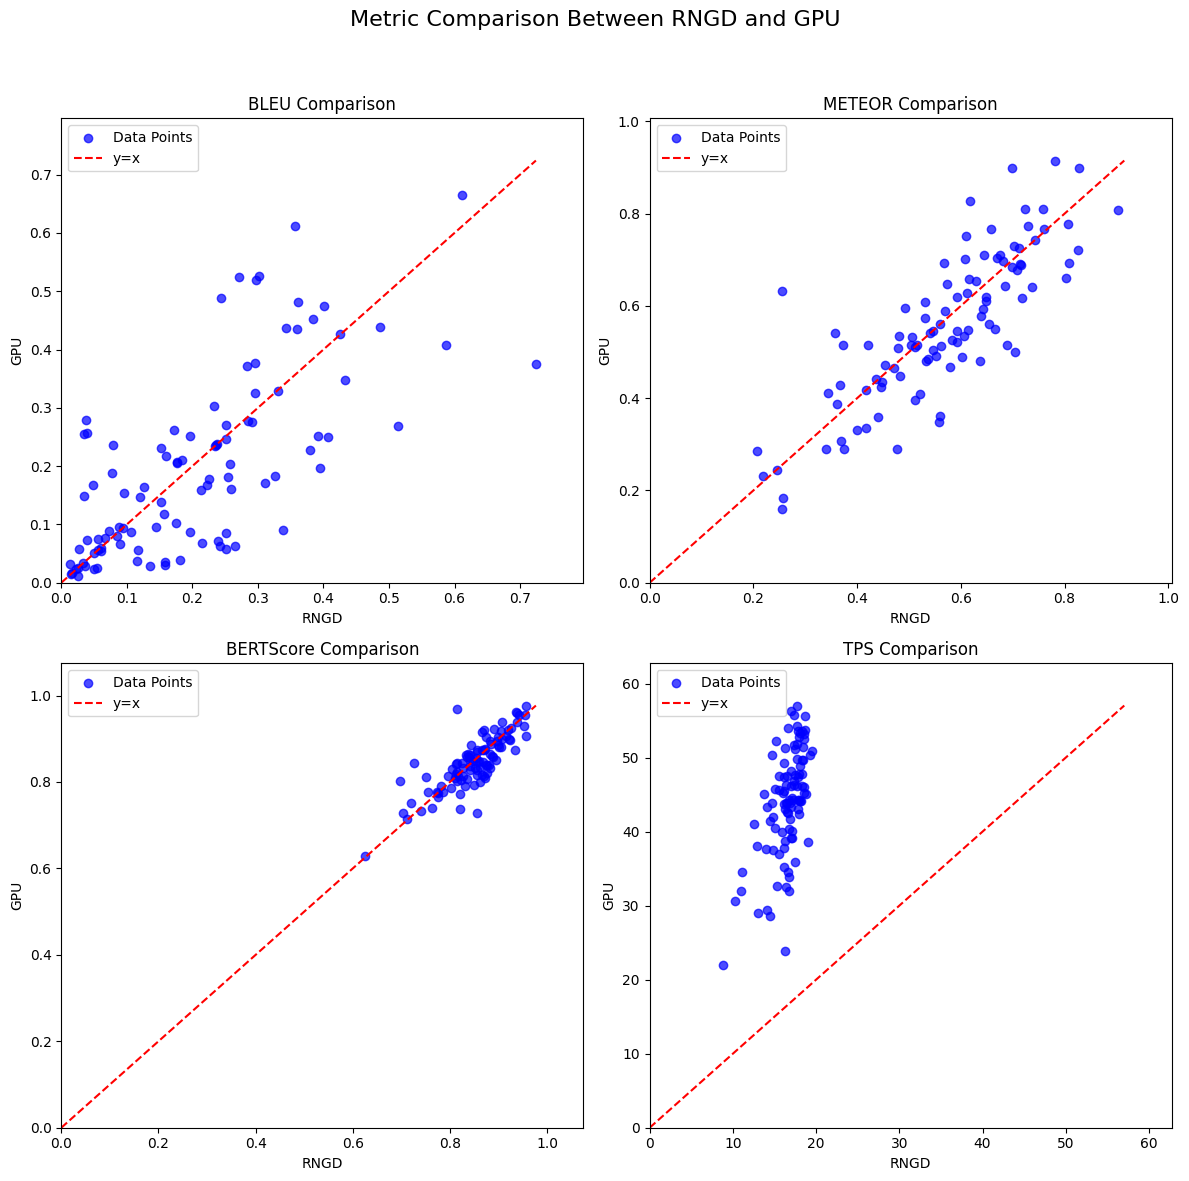

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 준비
metrics_labels = ["BLEU", "METEOR", "BERTScore", "TPS"]
num_metrics = len(metrics_labels)

# 각 메트릭 데이터 추출 및 NaN 제거
data = {
    label: {
        "rngd": metrics["rngd"][i, ~np.isnan(metrics["rngd"][i, :])],
        "gpu": metrics["gpu"][i, ~np.isnan(metrics["gpu"][i, :])]
    }
    for i, label in enumerate(metrics_labels)
}

# Subplot 구성
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# 각 subplot에 데이터 비교
for idx, label in enumerate(metrics_labels):
    ax = axes[idx // 2, idx % 2]
    
    # RNGD와 GPU 데이터 준비
    rngd_data = data[label]["rngd"]
    gpu_data = data[label]["gpu"]
    
    # 산점도 그리기
    ax.scatter(rngd_data, gpu_data, alpha=0.7, label="Data Points", color="blue")
    
    # y=x 선 추가
    max_val = max(np.max(rngd_data), np.max(gpu_data))
    ax.plot([0, max_val], [0, max_val], linestyle="--", color="red", label="y=x")
    
    # 축 및 타이틀 설정
    ax.set_title(f"{label} Comparison")
    ax.set_xlabel("RNGD")
    ax.set_ylabel("GPU")
    ax.set_xlim(0, max_val + max_val * 0.1)
    ax.set_ylim(0, max_val + max_val * 0.1)
    ax.legend()

# 전체 그래프 제목 및 레이아웃
fig.suptitle("Metric Comparison Between RNGD and GPU", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [4]:
# 모든 번역에 대해 평가 수행
metrics_rngd = []
for i, translation_data in enumerate(translations):
    ref_text = data_eng[i] if i < len(data_eng) else ""  # 참조 텍스트 매칭

    # 메트릭 계산
    metrics = evaluate_translation(translation_data["translation"], ref_text, target_lang, translation_data["elapsed_time"], all_configs["active_metrics"])
    metrics_results.append(metrics)

# 최종 결과 출력
print("Metrics Results:", metrics_results)

/home/dudaji/miniconda3/envs/langserve/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/dudaji/miniconda3/envs/langserve/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Metrics Results: [{'BLEU': 0.0145, 'METEOR': 0.2551, 'tps': 16.161870831363245, 'BERTScore': 0.7027}, {'BLEU': 0.5869, 'METEOR': 0.8023, 'tps': 16.116805899601395, 'BERTScore': 0.9519}, {'BLEU': 0.2346, 'METEOR': 0.5413, 'tps': 17.23447842402981, 'BERTScore': 0.8546}, {'BLEU': 0.259, 'METEOR': 0.6366, 'tps': 17.665893278875213, 'BERTScore': 0.8109}, {'BLEU': 0.048, 'METEOR': 0.5057, 'tps': 18.33833288714479, 'BERTScore': 0.8351}, {'BLEU': 0.1516, 'METEOR': 0.5029, 'tps': 17.071876589942406, 'BERTScore': 0.8572}, {'BLEU': 0.0255, 'METEOR': 0.2451, 'tps': 14.085658034481167, 'BERTScore': 0.7747}, {'BLEU': 0.0493, 'METEOR': 0.3682, 'tps': 16.109005846036617, 'BERTScore': 0.8204}, {'BLEU': 0.3013, 'METEOR': 0.8285, 'tps': 13.078631364612924, 'BERTScore': 0.939}, {'BLEU': 0.0955, 'METEOR': 0.5314, 'tps': 16.916467527409196, 'BERTScore': 0.8805}, {'BLEU': 0.0795, 'METEOR': 0.5678, 'tps': 19.29725775507356, 'BERTScore': 0.8903}, {'BLEU': 0.0723, 'METEOR': 0.4835, 'tps': 17.86589199458184, 'BE

In [8]:
# 저장 경로
save_path = "/home/dudaji/Jun/llm-rag-chatbot/result/translated_eval_rngd.json"

# JSON 파일로 저장
with open(save_path, "w", encoding="utf-8") as file:
    json.dump(metrics_results, file, indent=4, ensure_ascii=False)


In [7]:
ref_text

'Some patients might have contracted the bug in the hospital, Dr. Moll thinks, and at least two were hospital health workers.'

In [8]:
translation_data["translation"]

'Dr. Moll believes that some patients may have contracted the disease at the hospital, and at least two of them were likely healthy hospital workers.'